# Notebook 60: Interpolating from MESA grids to a large population

In [53]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match 
# the first two digits in the notebook's title
nb_id = 60

## Imports

In [54]:
from pathlib import Path
from math import isnan, nan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm, to_rgba
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit, eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius
from src.util import (savefig_base, get_model_folder_base, get_model_dict, history_plot, 
                      hr_diagram_tracks_base, normarr, CODE_ROOT, DATA_ROOT, MESA_DATA_ROOT)

plt.style.use('./plotstyle.mplstyle')

In [55]:
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [56]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [57]:
Z_SUN = 0.017

### Utilities

In [58]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [59]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [60]:
def get_model_folder(model_id, project_folder, verbose=True):
    """Finds model folder given its id."""
    matches = list(project_folder.glob(f'{model_id}*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {project_folder}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {project_folder}')
        return           

In [61]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [62]:
def mesareader_operator(expression, object_to_call='h'):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'{object_to_call}.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}{object_to_call}.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


### Plotting

In [63]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax, handles

In [64]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

## Generating an interpolated population

Let us load and organize our grids first.

In [65]:
def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts

In [66]:
project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4'
model_dicts_00005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3'
model_dicts_0005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2'
model_dicts_005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'
model_dicts_02zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'
model_dicts_06zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'
model_dicts_08zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'
model_dicts_10zsun = load_models(project_folder)


In [67]:
all_model_dicts = {
    '0.0005': model_dicts_00005zsun,
    '0.005': model_dicts_0005zsun,
    '0.02': model_dicts_002zsun,
    '0.05': model_dicts_005zsun,
    '0.1': model_dicts_01zsun,
    '0.2': model_dicts_02zsun,
    '0.4': model_dicts_04zsun,
    '0.6': model_dicts_06zsun,
    '0.8': model_dicts_08zsun,
    '1.0': model_dicts_10zsun
}

final_core_prop_array_dict = {
    '0.0005': np.load(DATA_ROOT/'09_enhanced_w_core_props.npy'),
    '0.005': np.load(DATA_ROOT/'08_enhanced_w_core_props.npy'),
    '0.02': np.load(DATA_ROOT/'07_enhanced_w_core_props.npy'),
    '0.05': np.load(DATA_ROOT/'06_enhanced_w_core_props.npy'),
    '0.1': np.load(DATA_ROOT/'00_enhanced_w_core_props.npy'),
    '0.2': np.load(DATA_ROOT/'01_enhanced_w_core_props.npy'),
    '0.4': np.load(DATA_ROOT/'02_enhanced_w_core_props.npy'),
    '0.6': np.load(DATA_ROOT/'03_enhanced_w_core_props.npy'),
    '0.8': np.load(DATA_ROOT/'04_enhanced_w_core_props.npy'),
    '1.0': np.load(DATA_ROOT/'05_enhanced_w_core_props.npy')
}

In [68]:
## Select models
def get_m_p_guides(model_dicts):
    guide_m_str = []
    guide_p_str = []
    for m in model_dicts.keys():
        guide_m_str.append(m)
        for p in model_dicts[m]:
            guide_p_str.append(p)
    guide_p_str = np.unique(guide_p_str)
    guide_p_float = np.float64(guide_p_str)
    guide_p_str = guide_p_str[np.argsort(guide_p_float)]
    guide_p_float = np.sort(guide_p_float)
    
    guide_m_str = np.unique(guide_m_str)
    guide_m_float = np.float64(guide_m_str)
    guide_m_str = guide_m_str[np.argsort(guide_m_float)]
    guide_m_float = np.sort(guide_m_float)
    return guide_p_str, guide_p_float, guide_m_str, guide_m_float

In [69]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

In [70]:
def get_l2_pzams_mcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):

    interpolator_dict = dict()

    for i, m in enumerate(guide_m_float):
        m_key = guide_m_str[i]
        p_arr = guide_p_float   
        y_arr = final_core_prop_array[:, i, 0] 
        r_arr = final_core_prop_array[:, i, 6] 

        mask = np.array(final_core_prop_array[:, i, 9], bool)
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
            
        mask = []
        for p0, rzams in zip(p_arr, r_arr):
            isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
            if isof:
                mask.append(False)
            else:
                mask.append(True)
                
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
        
        if len(y_arr) == 0:
            y_arr = [nan]
            p_arr = [1]
            r_arr = [1]
        
        interpolator = interp1d(
            x=p_arr,
            y=y_arr,
            kind='linear',
            bounds_error=False,
            fill_value=nan
            )

        interpolator_dict[m_key] = interpolator     
        
    l2_pzams_mcore_interpolator_dict = interpolator_dict
    return l2_pzams_mcore_interpolator_dict


def l2_mzams_mcore_interpolator(m_zams, p_zams, l2_pzams_mcore_interpolator_dict, guide_m_str, guide_m_float):
    ip_m_cores = []
    for m_key in guide_m_str:
        interpolator = l2_pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=guide_m_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

def get_l2_mzams_mcore_interpolator_dict(guide_z_str):
    interpolator_dict = dict()
    for i, z_str in enumerate(guide_z_str):
        model_dicts = all_model_dicts[z_str]
        final_core_prop_array = final_core_prop_array_dict[z_str]
        guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(model_dicts)
        interpolator_dict[z_str] = get_l2_pzams_mcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    return interpolator_dict

def l2_z_mcore_interpolator(z_div_zsun, m_zams, p_zams, l2_mzams_mcore_interpolator_dict, guide_z_str, guide_z_float,
                            guide_m_str, guide_m_float):
    ip_m_cores = []
    for z_key in guide_z_str:
        l2_pzams_mcore_interpolator_dict = l2_mzams_mcore_interpolator_dict[z_key]
        m_core = l2_mzams_mcore_interpolator(m_zams, p_zams, l2_pzams_mcore_interpolator_dict, guide_m_str, guide_m_float)
        ip_m_cores.append(m_core)      
                
    interpolator = interp1d(
        x=guide_z_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(z_div_zsun)
    
    return m_core

In [71]:
def get_l2_pzams_xcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):

    interpolator_dict = dict()

    for i, m in enumerate(guide_m_float):
        m_key = guide_m_str[i]
        p_arr = guide_p_float   
        y_arr = final_core_prop_array[:, i, 1] 
        r_arr = final_core_prop_array[:, i, 6] 

        mask = np.array(final_core_prop_array[:, i, 9], bool)
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
            
        mask = []
        for p0, rzams in zip(p_arr, r_arr):
            isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
            if isof:
                mask.append(False)
            else:
                mask.append(True)
                
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
        
        if len(y_arr) == 0:
            y_arr = [nan]
            p_arr = [1]
            r_arr = [1]
        
        interpolator = interp1d(
            x=p_arr,
            y=y_arr,
            kind='linear',
            bounds_error=False,
            fill_value=nan
            )

        interpolator_dict[m_key] = interpolator     
        
    l2_pzams_xcore_interpolator_dict = interpolator_dict
    return l2_pzams_xcore_interpolator_dict


def l2_mzams_xcore_interpolator(m_zams, p_zams, l2_pzams_xcore_interpolator_dict, guide_m_str, guide_m_float):
    ip_x_cores = []
    for m_key in guide_m_str:
        interpolator = l2_pzams_xcore_interpolator_dict[m_key]
        ip_x_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=guide_m_float,
        y=ip_x_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    x_core = interpolator(m_zams)
    
    return x_core  

def get_l2_mzams_xcore_interpolator_dict(guide_z_str):
    interpolator_dict = dict()
    for i, z_str in enumerate(guide_z_str):
        model_dicts = all_model_dicts[z_str]
        final_core_prop_array = final_core_prop_array_dict[z_str]
        guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(model_dicts)
        interpolator_dict[z_str] = get_l2_pzams_xcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    return interpolator_dict

def l2_z_xcore_interpolator(z_div_zsun, m_zams, p_zams, l2_mzams_xcore_interpolator_dict, guide_z_str, guide_z_float,
                            guide_m_str, guide_m_float):
    ip_x_cores = []
    for z_key in guide_z_str:
        l2_pzams_xcore_interpolator_dict = l2_mzams_xcore_interpolator_dict[z_key]
        x_core = l2_mzams_xcore_interpolator(m_zams, p_zams, l2_pzams_xcore_interpolator_dict, guide_m_str, guide_m_float)
        ip_x_cores.append(x_core)      
                
    interpolator = interp1d(
        x=guide_z_float,
        y=ip_x_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    x_core = interpolator(z_div_zsun)
    
    return x_core

In [72]:
def get_l2_pzams_tdelay_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):

    interpolator_dict = dict()

    for i, m in enumerate(guide_m_float):
        m_key = guide_m_str[i]
        p_arr = guide_p_float   
        y_arr = final_core_prop_array[:, i, 11] 
        r_arr = final_core_prop_array[:, i, 6] 

        mask = np.array(final_core_prop_array[:, i, 9], bool)
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
            
        mask = []
        for p0, rzams in zip(p_arr, r_arr):
            isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
            if isof:
                mask.append(False)
            else:
                mask.append(True)
                
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
        
        if len(y_arr) == 0:
            y_arr = [nan]
            p_arr = [1]
            r_arr = [1]
        
        interpolator = interp1d(
            x=p_arr,
            y=y_arr,
            kind='linear',
            bounds_error=False,
            fill_value=nan
            )

        interpolator_dict[m_key] = interpolator     
        
    l2_pzams_tdelay_interpolator_dict = interpolator_dict
    return l2_pzams_tdelay_interpolator_dict


def l2_mzams_tdelay_interpolator(m_zams, p_zams, l2_pzams_tdelay_interpolator_dict, guide_m_str, guide_m_float):
    ip_t_delays = []
    for m_key in guide_m_str:
        interpolator = l2_pzams_tdelay_interpolator_dict[m_key]
        ip_t_delays.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=guide_m_float,
        y=ip_t_delays,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    t_delay = interpolator(m_zams)
    
    return t_delay  

def get_l2_mzams_tdelay_interpolator_dict(guide_z_str):
    interpolator_dict = dict()
    for i, z_str in enumerate(guide_z_str):
        model_dicts = all_model_dicts[z_str]
        final_core_prop_array = final_core_prop_array_dict[z_str]
        guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(model_dicts)
        interpolator_dict[z_str] = get_l2_pzams_tdelay_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    return interpolator_dict

def l2_z_tdelay_interpolator(z_div_zsun, m_zams, p_zams, l2_mzams_tdelay_interpolator_dict, guide_z_str, guide_z_float,
                            guide_m_str, guide_m_float):
    ip_t_delays = []
    for z_key in guide_z_str:
        l2_pzams_tdelay_interpolator_dict = l2_mzams_tdelay_interpolator_dict[z_key]
        t_delay = l2_mzams_tdelay_interpolator(m_zams, p_zams, l2_pzams_tdelay_interpolator_dict, guide_m_str, guide_m_float)
        ip_t_delays.append(t_delay)      
                
    interpolator = interp1d(
        x=guide_z_float,
        y=ip_t_delays,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    t_delay = interpolator(z_div_zsun)
    
    return t_delay

In [73]:
def base_set_cores(sample, l2_pzams_mcore_interpolator_dict, l2_pzams_xcore_interpolator_dict, l2_pzams_tdelay_interpolator_dict, guide_m_str, guide_m_float):
    for i, star in enumerate(sample):
        r = star[2]
        isof = is_of(r=r, m=star[0], p=star[1], q=1, kind='L2')
        if isof:
            mcore = nan
            xcore = nan
            tdelay = nan
        else:
            mcore = l2_mzams_mcore_interpolator(star[0], star[1], l2_pzams_mcore_interpolator_dict, guide_m_str, guide_m_float)
            xcore = l2_mzams_xcore_interpolator(star[0], star[1], l2_pzams_xcore_interpolator_dict, guide_m_str, guide_m_float)
            tdelay = l2_mzams_tdelay_interpolator(star[0], star[1], l2_pzams_tdelay_interpolator_dict, guide_m_str, guide_m_float)
        sample[i, 3] = mcore
        sample[i, 4] = xcore
        sample[i, 5] = tdelay
    return sample

In [74]:
def base_set_cores_freemet(
    sample,
    l2_mzams_mcore_interpolator_dict, 
    l2_mzams_xcore_interpolator_dict, 
    l2_mzams_tdelay_interpolator_dict,
    guide_z_str, 
    guide_z_float,
    guide_m_str, 
    guide_m_float
    ):
    
    for i, star in enumerate(sample):
        r = star[3]
        isof = is_of(r=r, m=star[1], p=star[2], q=1, kind='L2')
        if isof:
            mcore = nan
            xcore = nan
            tdelay = nan
        else:
            mcore = l2_z_mcore_interpolator(
                star[0], 
                star[1], 
                star[2], 
                l2_mzams_mcore_interpolator_dict, 
                guide_z_str, 
                guide_z_float,
                guide_m_str, 
                guide_m_float
                )
            xcore = l2_z_xcore_interpolator(
                star[0], 
                star[1], 
                star[2],
                l2_mzams_xcore_interpolator_dict, 
                guide_z_str, 
                guide_z_float, 
                guide_m_str, 
                guide_m_float
                )
            tdelay = l2_z_tdelay_interpolator(
                star[0], 
                star[1], 
                star[2],
                l2_mzams_tdelay_interpolator_dict, 
                guide_z_str, 
                guide_z_float, 
                guide_m_str, 
                guide_m_float
                )
        sample[i, 4] = mcore
        sample[i, 5] = xcore
        sample[i, 6] = tdelay
    return sample

In [75]:
def get_l2_pzams_rzams_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):
    interpolator_dict = dict()

    for i, m in enumerate(guide_m_float):
        m_key = guide_m_str[i]
        p_arr = guide_p_float   
        y_arr = final_core_prop_array[:, i, 6] 
        r_arr = final_core_prop_array[:, i, 6] 
        
        mask = np.array(final_core_prop_array[:, i, 9], bool)
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
    
        mask = []
        for p0, rzams in zip(p_arr, r_arr):
            isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
            if isof:
                mask.append(False)
            else:
                mask.append(True)
        
        y_arr = y_arr[mask]
        p_arr = p_arr[mask]
        r_arr = r_arr[mask]
        
        if len(y_arr) == 0:
            y_arr = [nan]
            p_arr = [1]
            r_arr = [1]
        
        interpolator = interp1d(
            x=p_arr,
            y=y_arr,
            kind='linear',
            bounds_error=False,
            fill_value=nan
            )

        interpolator_dict[m_key] = interpolator     
        
    l2_pzams_rzams_interpolator_dict = interpolator_dict
    return l2_pzams_rzams_interpolator_dict

def l2_mzams_rzams_interpolator(m_zams, p_zams, l2_pzams_rzams_interpolator_dict, guide_m_str, guide_m_float):
    ip_m_cores = []
    for m_key in guide_m_str:
        interpolator = l2_pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=guide_m_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    r_zams = interpolator(m_zams)
    
    return r_zams

def get_l2_mzams_rzams_interpolator_dict(guide_z_str):
    interpolator_dict = dict()
    for i, z_str in enumerate(guide_z_str):
        model_dicts = all_model_dicts[z_str]
        final_core_prop_array = final_core_prop_array_dict[z_str]
        guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(model_dicts)
        interpolator_dict[z_str] = get_l2_pzams_rzams_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    return interpolator_dict

def l2_z_rzams_interpolator(z_div_zsun, m_zams, p_zams, l2_mzams_rzams_interpolator_dict, guide_z_str, guide_z_float,
                            guide_m_str, guide_m_float):
    ip_r_zamss = []
    for z_key in guide_z_str:
        l2_pzams_rzams_interpolator_dict = l2_mzams_rzams_interpolator_dict[z_key]
        r_zams = l2_mzams_rzams_interpolator(m_zams, p_zams, l2_pzams_rzams_interpolator_dict, guide_m_str, guide_m_float)
        ip_r_zamss.append(r_zams)      
                
    interpolator = interp1d(
        x=guide_z_float,
        y=ip_r_zamss,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    r_zams = interpolator(z_div_zsun)
    
    return r_zams


In [76]:
def get_set_cores(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):
    l2_pzams_mcore_interpolator_dict = get_l2_pzams_mcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    l2_pzams_xcore_interpolator_dict = get_l2_pzams_xcore_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    l2_pzams_tdelay_interpolator_dict = get_l2_pzams_tdelay_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    def set_cores(sample):
        return base_set_cores(sample, l2_pzams_mcore_interpolator_dict, l2_pzams_xcore_interpolator_dict, l2_pzams_tdelay_interpolator_dict, guide_m_str, guide_m_float)
    return set_cores

def get_set_rzams(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array):
    l2_pzams_rzams_interpolator_dict = get_l2_pzams_rzams_interpolator_dict(guide_m_str, guide_m_float, guide_p_float, final_core_prop_array)
    def set_rzams(m, p):
        return l2_mzams_rzams_interpolator(m, p, l2_pzams_rzams_interpolator_dict, guide_m_str, guide_m_float)
    return set_rzams

In [77]:
def get_set_cores_freemet(guide_z_float, guide_z_str, guide_m_str, guide_m_float):
    l2_mzams_mcore_interpolator_dict = get_l2_mzams_mcore_interpolator_dict(guide_z_str)
    l2_mzams_xcore_interpolator_dict = get_l2_mzams_xcore_interpolator_dict(guide_z_str)
    l2_mzams_tdelay_interpolator_dict = get_l2_mzams_tdelay_interpolator_dict(guide_z_str)
    def set_cores(sample):
        return base_set_cores_freemet(
            sample, 
            l2_mzams_mcore_interpolator_dict, 
            l2_mzams_xcore_interpolator_dict, 
            l2_mzams_tdelay_interpolator_dict,
            guide_z_str, 
            guide_z_float,
            guide_m_str, 
            guide_m_float
            )
    return set_cores

def get_set_rzams_freemet(guide_z_float, guide_z_str, guide_m_str, guide_m_float):
    l2_mzams_rzams_interpolator_dict = get_l2_mzams_rzams_interpolator_dict(guide_z_str)
    def set_rzams(z, m, p):
        return l2_z_rzams_interpolator(
            z,
            m,
            p,
            l2_mzams_rzams_interpolator_dict,
            guide_z_str,
            guide_z_float,
            guide_m_str,
            guide_m_float
        )
    return set_rzams

def get_ip_dicts_freemet(guide_z_str):
    l2_mzams_mcore_interpolator_dict = get_l2_mzams_mcore_interpolator_dict(guide_z_str)
    l2_mzams_xcore_interpolator_dict = get_l2_mzams_xcore_interpolator_dict(guide_z_str)
    l2_mzams_tdelay_interpolator_dict = get_l2_mzams_tdelay_interpolator_dict(guide_z_str)
    l2_mzams_rzams_interpolator_dict = get_l2_mzams_rzams_interpolator_dict(guide_z_str)
    return (
        l2_mzams_mcore_interpolator_dict,
        l2_mzams_xcore_interpolator_dict,
        l2_mzams_tdelay_interpolator_dict,
        l2_mzams_rzams_interpolator_dict
    )

In [78]:
l2_mzams_mcore_interpolator_dict, l2_mzams_xcore_interpolator_dict, l2_mzams_tdelay_interpolator_dict, l2_mzams_rzams_interpolator_dict = get_ip_dicts_freemet(all_model_dicts.keys())  

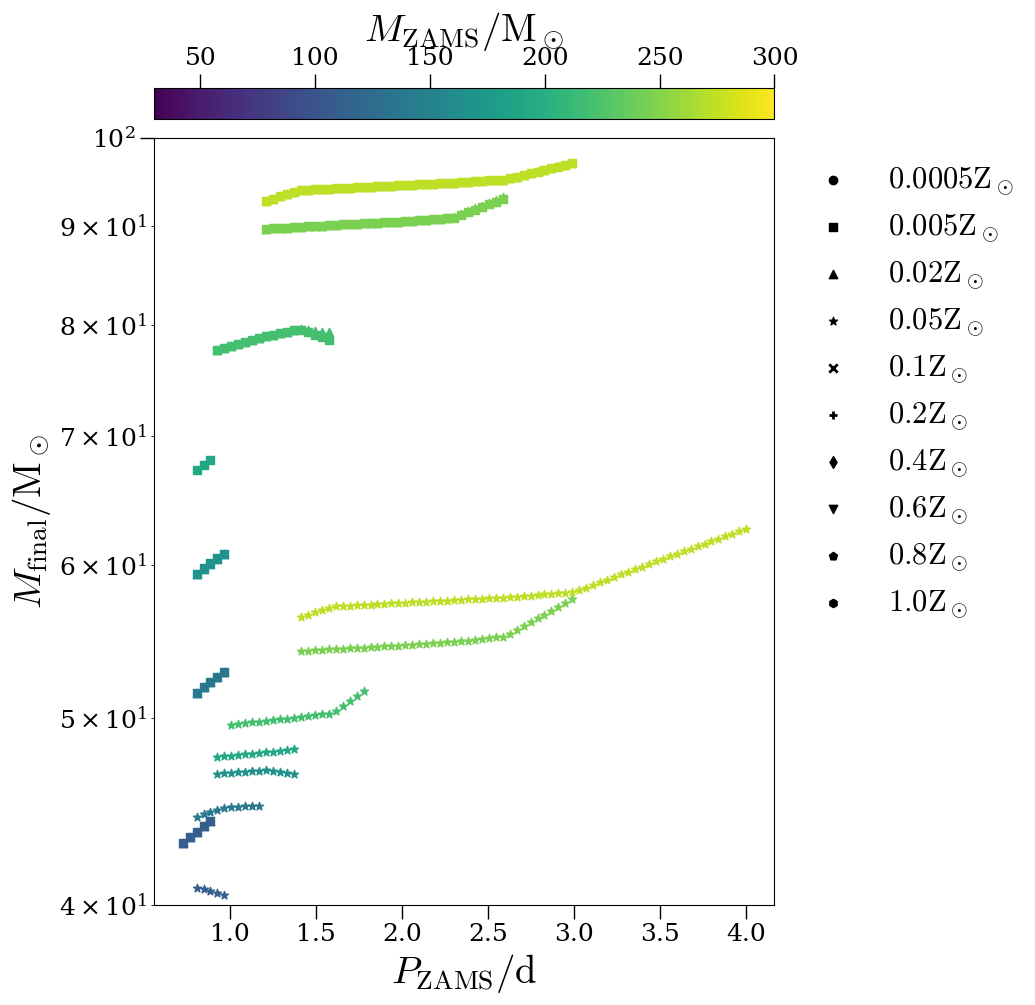

In [79]:
fig, ax = plt.subplots(figsize=(8, 12))

met_m = {
    '0.0005': 'o',
    '0.005': 's',
    '0.02': '^',
    '0.05': '*',
    '0.1': 'x',
    '0.2': '+',
    '0.4': 'd',
    '0.6': 'v',
    '0.8': 'p',
    '1.0': 'h'
}

for z in l2_mzams_mcore_interpolator_dict.keys():
    if z not in ['0.05', '0.02', '0.005']:
        continue
    for i, m in enumerate(l2_mzams_mcore_interpolator_dict[z].keys()):
        c = cm.viridis(i/10)
        ax.scatter(np.linspace(0, 4, 100), l2_mzams_mcore_interpolator_dict[z][m](np.linspace(0, 4, 100)), color=c, marker=met_m[z])
ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_yscale('log')

ax.set_ylim(40, 100)

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=30, vmax=300))
cb = fig.colorbar(sm, ax=ax, location='top', pad=0.02)
cb.set_label('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')

In [80]:
from astropy.cosmology import WMAP9 as cosmo
th = cosmo.age(0).to(u.yr).value

Text(4, 35, '$35\\,\\mathrm{M}_\\odot$')

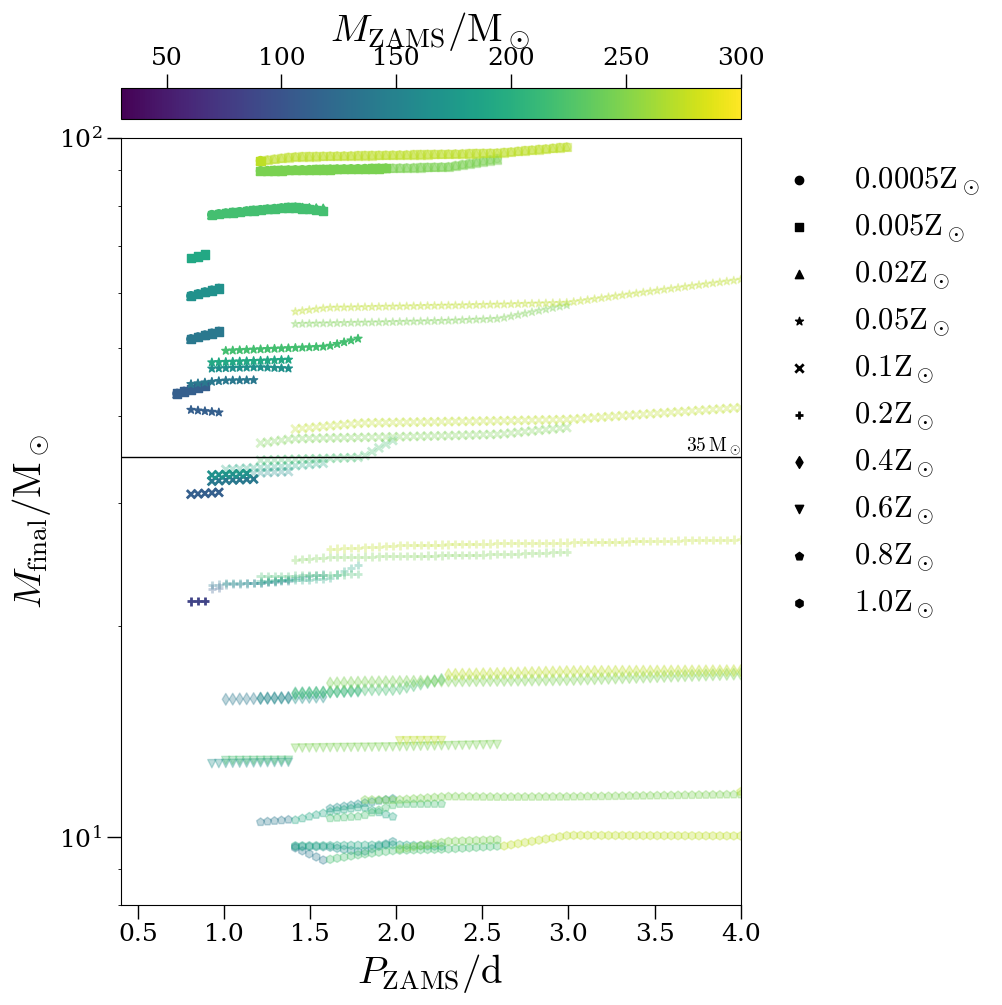

In [81]:
fig, ax = plt.subplots(figsize=(8, 12))

met_m = {
    '0.0005': 'o',
    '0.005': 's',
    '0.02': '^',
    '0.05': '*',
    '0.1': 'x',
    '0.2': '+',
    '0.4': 'd',
    '0.6': 'v',
    '0.8': 'p',
    '1.0': 'h'
}

for z in l2_mzams_mcore_interpolator_dict.keys():
    #if z not in ['0.6', '0.8', '1.0']:
        #continue
    for i, m in enumerate(l2_mzams_mcore_interpolator_dict[z].keys()):
        c = cm.viridis(i/10)
        td = l2_mzams_tdelay_interpolator_dict[z][m](np.linspace(0, 4, 100))
        alpha = []
        for t in td:
            if t > th:
                alpha.append(0.3)
            else:
                alpha.append(1)
        ax.scatter(np.linspace(0, 4, 100), l2_mzams_mcore_interpolator_dict[z][m](np.linspace(0, 4, 100)), color=c, marker=met_m[z], alpha=alpha)
ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=30, vmax=300))
cb = fig.colorbar(sm, ax=ax, location='top', pad=0.02)
cb.set_label('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')

ax.set_xlim(0.4, 4)
ax.set_ylim(8, 100)
ax.hlines(35, 0.4, 4, color='k', ls='-', lw=1)
ax.text(4, 35, '$35\\,\\mathrm{M}_\\odot$', color='k', fontsize=14, ha='right', va='bottom')

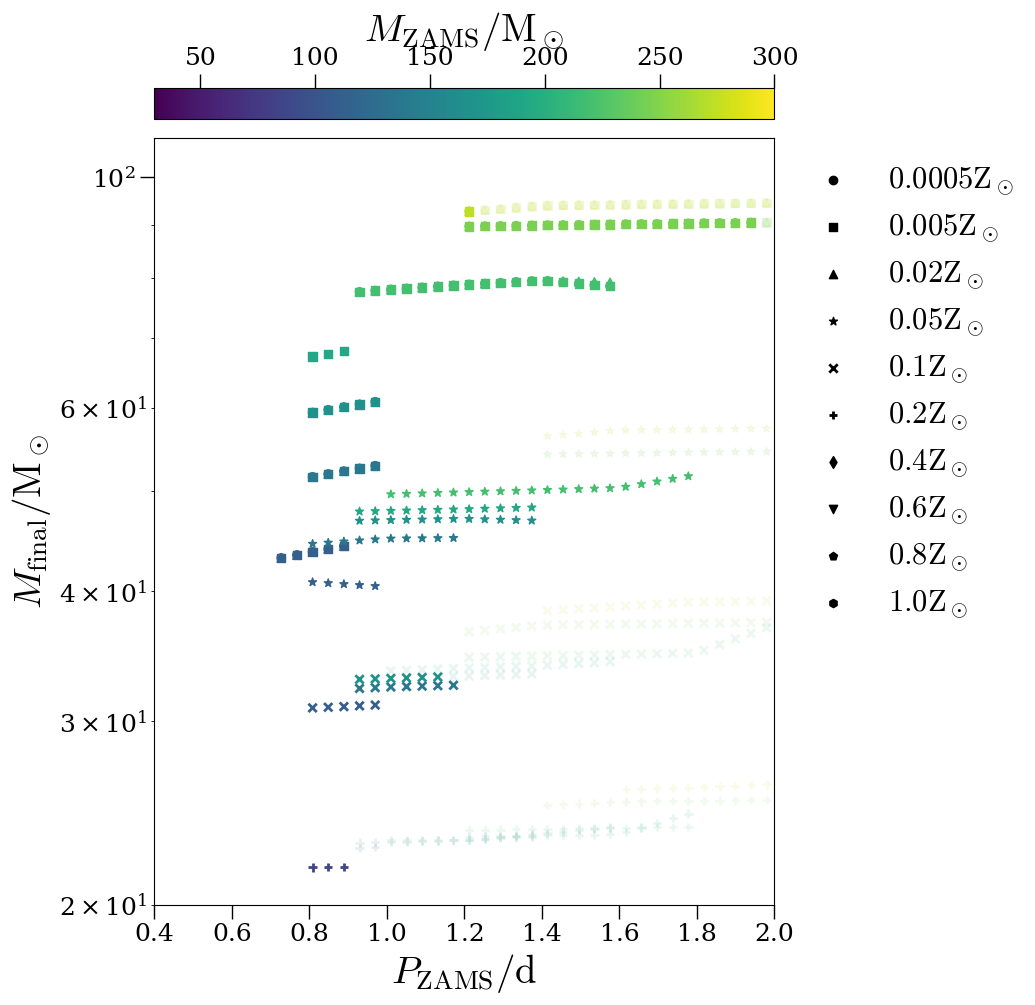

In [82]:
fig, ax = plt.subplots(figsize=(8, 12))

met_m = {
    '0.0005': 'o',
    '0.005': 's',
    '0.02': '^',
    '0.05': '*',
    '0.1': 'x',
    '0.2': '+',
    '0.4': 'd',
    '0.6': 'v',
    '0.8': 'p',
    '1.0': 'h'
}

for z in l2_mzams_mcore_interpolator_dict.keys():
    #if z not in ['0.6', '0.8', '1.0']:
        #continue
    for i, m in enumerate(l2_mzams_mcore_interpolator_dict[z].keys()):
        c = cm.viridis(i/10)
        td = l2_mzams_tdelay_interpolator_dict[z][m](np.linspace(0, 4, 100))
        alpha = []
        for t in td:
            if t > th:
                alpha.append(0.1)
            else:
                alpha.append(1)
        ax.scatter(np.linspace(0, 4, 100), l2_mzams_mcore_interpolator_dict[z][m](np.linspace(0, 4, 100)), color=c, marker=met_m[z], alpha=alpha)
ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
ax.set_yscale('log')
ax.set_xlim(0.4, 2)
ax.set_ylim(20)

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=30, vmax=300))
cb = fig.colorbar(sm, ax=ax, location='top', pad=0.02)
cb.set_label('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')

Text(1.02, 0.6, 'Shaded areas indicate where\nmodels for the same $M_\\mathrm{ZAMS}$\nare available at all metallicities')

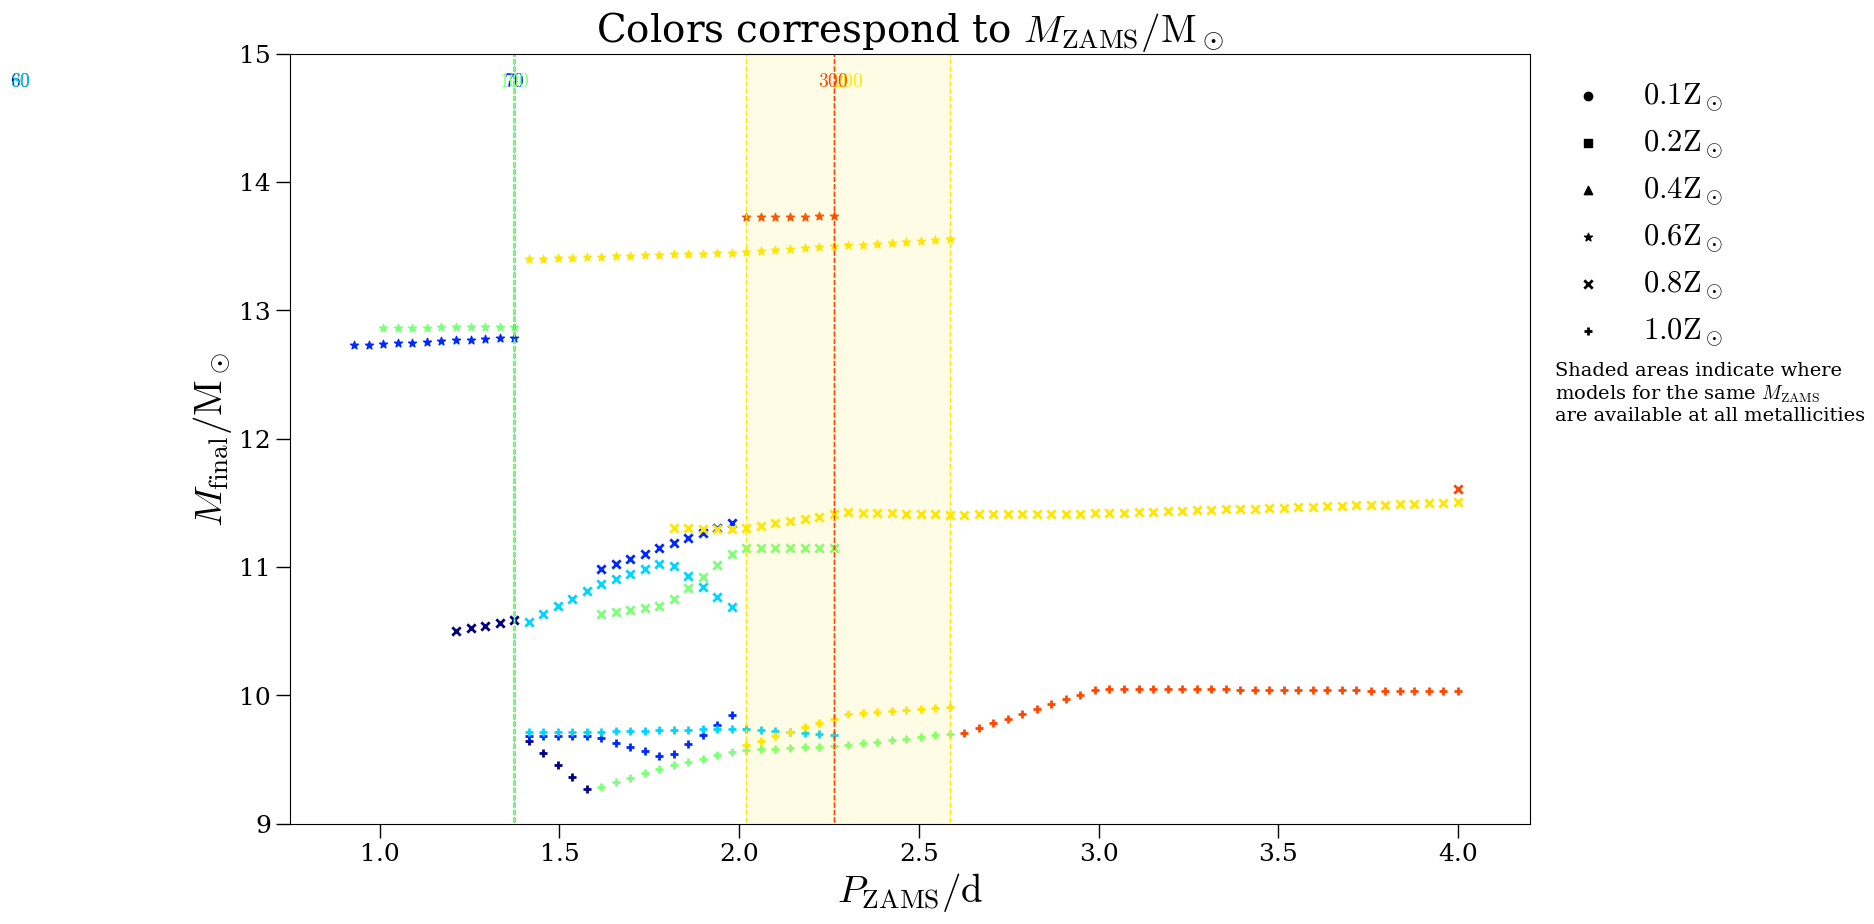

In [83]:
fig, ax = plt.subplots(figsize=(16, 10))
maxy = 15
cmap = cm.jet

met_m = {
    '0.1': 'o',
    '0.2': 's',
    '0.4': '^',
    '0.6': '*',
    '0.8': 'x',
    '1.0': '+'
}

overlap_dict = dict()

pzams_arr = np.linspace(0, 4, 100)
mkeys_to_plot = ['60.0', '70.0', '80.0', '100.0', '200.0', '300.0']

for z in l2_mzams_mcore_interpolator_dict.keys():
    if z not in ['0.6', '0.8', '1.0']:
        continue
    for i, m in enumerate(mkeys_to_plot):
        ip = l2_mzams_mcore_interpolator_dict[z][m]
        mfinal_arr = ip(pzams_arr)
        c = cmap(i/len(mkeys_to_plot))
        ax.scatter(pzams_arr, mfinal_arr, color=c, marker=met_m[z])
        
        if m not in overlap_dict.keys():
            overlap_dict[m] = (0, len(pzams_arr)-1)
        try:
            min_p_i = np.where(~np.isnan(mfinal_arr))[0][0]
        except IndexError:
            min_p_i = 0
            max_p_i = 0
            overlap_dict[m] = (0, 0)
            
        else:
            max_p_i = np.where(~np.isnan(mfinal_arr))[0][-1]

        if min_p_i > overlap_dict[m][0]:
            overlap_dict[m] = (min(min_p_i, overlap_dict[m][1]), overlap_dict[m][1])
        if max_p_i < overlap_dict[m][1]:    
            overlap_dict[m] = (overlap_dict[m][0], max(max_p_i, overlap_dict[m][0]))
            
for i, m in enumerate(overlap_dict.keys()):
    c = cmap(i/len(overlap_dict.keys()))
    min_p_i, max_p_i = overlap_dict[m]

    ax.vlines(pzams_arr[min_p_i], 0, 100, color=c, ls='--', lw=1)
    ax.vlines(pzams_arr[max_p_i], 0, 100, color=c, ls='--', lw=1)
    ax.axvspan(pzams_arr[min_p_i], pzams_arr[max_p_i], color=c, alpha=0.1, lw=0)   
    ax.text(
        (pzams_arr[min_p_i]+pzams_arr[max_p_i])/2,
        maxy*0.99,
        f'${float(m):.0f}$',
        color=c,
        transform=ax.transData,
        ha='center',
        va='top',
        fontsize=14
    )


ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
#ax.set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

ax.set_ylim(9, 15)
ax.set_xlim(0.75)

ax.set_title('Colors correspond to $M_\mathrm{ZAMS}/\mathrm{M}_\odot$')
ax.text(1.02, 0.6, 'Shaded areas indicate where\nmodels for the same $M_\mathrm{ZAMS}$\nare available at all metallicities', ha='left', va='top', transform=ax.transAxes, fontsize=14)

Text(1.02, 0.6, 'Shaded areas indicate where\nmodels for the same $M_\\mathrm{ZAMS}$\nare available at all metallicities')

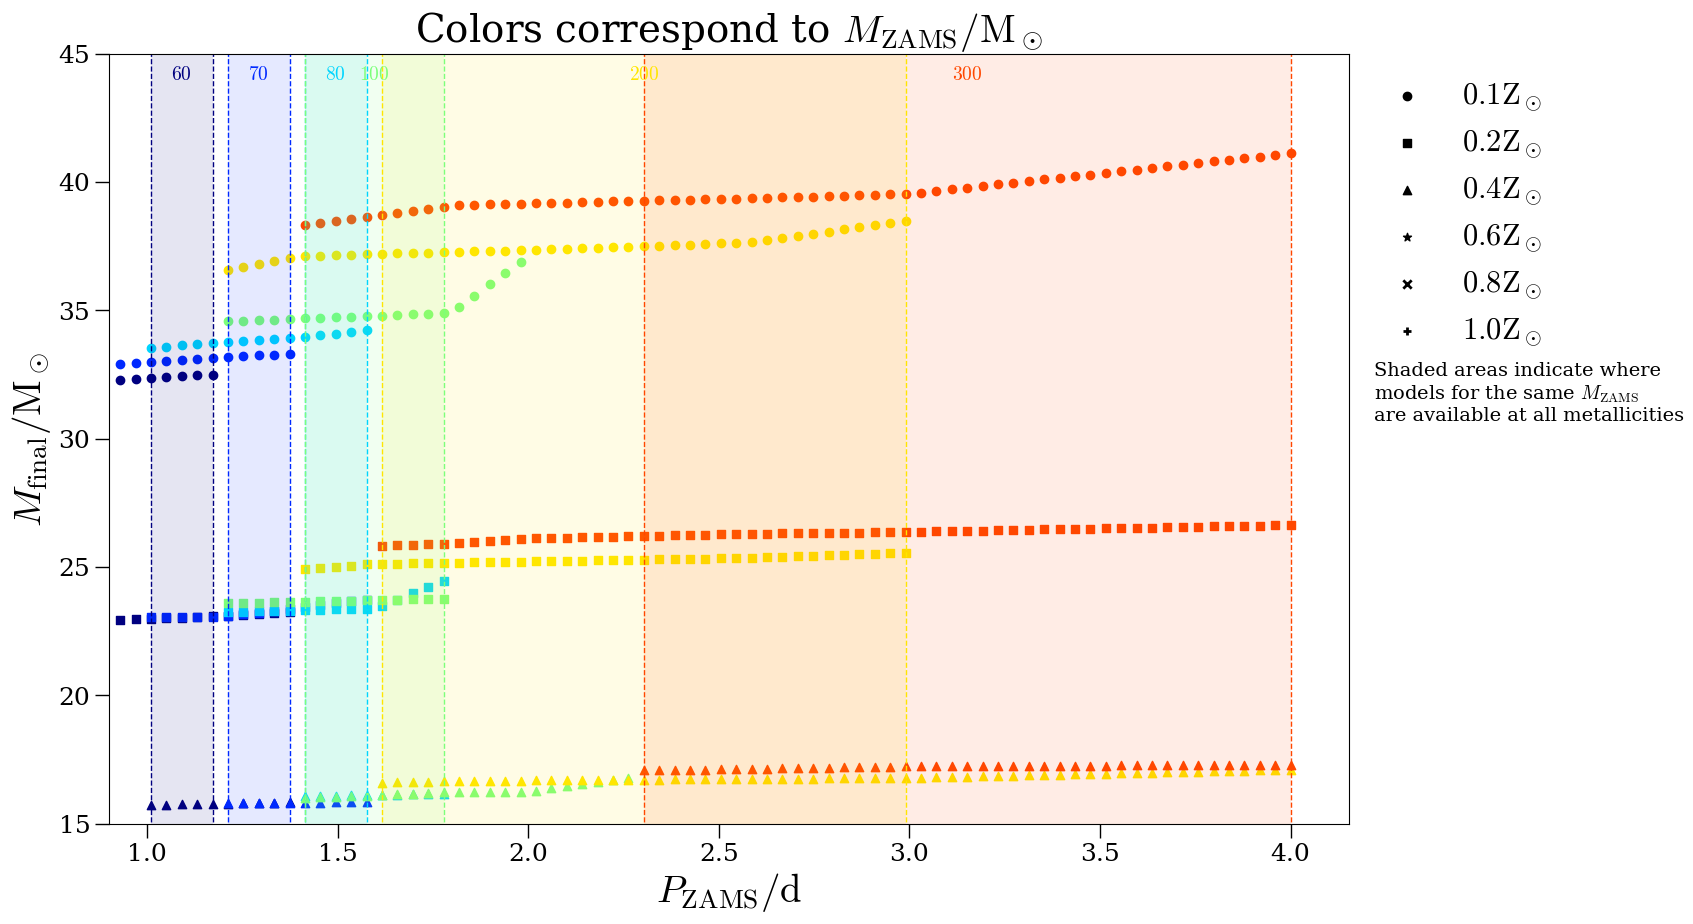

In [84]:
fig, ax = plt.subplots(figsize=(16, 10))
maxy = 45
cmap = cm.jet

met_m = {
    '0.1': 'o',
    '0.2': 's',
    '0.4': '^',
    '0.6': '*',
    '0.8': 'x',
    '1.0': '+'
}

overlap_dict = dict()

pzams_arr = np.linspace(0, 4, 100)
mkeys_to_plot = ['60.0', '70.0', '80.0', '100.0', '200.0', '300.0']

for z in l2_mzams_mcore_interpolator_dict.keys():
    if z in ['0.0005', '0.005', '0.02', '0.05', '0.6', '0.8', '1.0']:
        continue
    for i, m in enumerate(mkeys_to_plot):
        ip = l2_mzams_mcore_interpolator_dict[z][m]
        mfinal_arr = ip(pzams_arr)
        c = cmap(i/len(mkeys_to_plot))
        ax.scatter(pzams_arr, mfinal_arr, color=c, marker=met_m[z])
        
        if m not in overlap_dict.keys():
            overlap_dict[m] = (0, len(pzams_arr)-1)
        try:
            min_p_i = np.where(~np.isnan(mfinal_arr))[0][0]
        except IndexError:
            min_p_i = 0
            max_p_i = 0
            overlap_dict[m] = (0, 0)
            
        else:
            max_p_i = np.where(~np.isnan(mfinal_arr))[0][-1]

        if min_p_i > overlap_dict[m][0]:
            overlap_dict[m] = (min(min_p_i, overlap_dict[m][1]), overlap_dict[m][1])
        if max_p_i < overlap_dict[m][1]:    
            overlap_dict[m] = (overlap_dict[m][0], max(max_p_i, overlap_dict[m][0]))
            
for i, m in enumerate(overlap_dict.keys()):
    c = cmap(i/len(overlap_dict.keys()))
    min_p_i, max_p_i = overlap_dict[m]

    ax.vlines(pzams_arr[min_p_i], 0, 100, color=c, ls='--', lw=1)
    ax.vlines(pzams_arr[max_p_i], 0, 100, color=c, ls='--', lw=1)
    ax.axvspan(pzams_arr[min_p_i], pzams_arr[max_p_i], color=c, alpha=0.1, lw=0)   
    ax.text(
        (pzams_arr[min_p_i]+pzams_arr[max_p_i])/2,
        maxy*0.99,
        f'${float(m):.0f}$',
        color=c,
        transform=ax.transData,
        ha='center',
        va='top',
        fontsize=14
    )


ax.set_xlabel('$P_\mathrm{ZAMS}/\mathrm{d}$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')
#ax.set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
for label in met_m.keys():
    marker = met_m[label]
    handles.append(ax.scatter([], [], color='k', marker=marker, label=f'${label}\mathrm{{Z}}_\odot$'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

ax.set_ylim(15, maxy)
ax.set_xlim(0.9)

ax.set_title('Colors correspond to $M_\mathrm{ZAMS}/\mathrm{M}_\odot$')
ax.text(1.02, 0.6, 'Shaded areas indicate where\nmodels for the same $M_\mathrm{ZAMS}$\nare available at all metallicities', ha='left', va='top', transform=ax.transAxes, fontsize=14)

In [85]:
def draw_mass_sample(
    set_cores,
    set_rzams,
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=None,
    max_mfinal=None,
    mfinal_bin_width=0.1
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([set_rzams(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))
    sample_xcores = np.zeros(int(res/100))
    sample_delay_times = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores, sample_xcores, sample_delay_times]).T
    zams_l2of_sample = set_cores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]
    
    if min_mfinal is None:
        min_mfinal = min(mass_draw)
    if max_mfinal is None:
        max_mfinal = max(mass_draw)

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [86]:
def draw_mass_sample_freemet(
    set_cores,
    set_rzams,
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_zdivzsun=0.1,
    max_zdivzsun=1.0,
    min_mfinal=None,
    max_mfinal=None,
    mfinal_bin_width=0.1
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))
    
    sample_zs = np.linspace(np.log10(min_zdivzsun), np.log10(max_zdivzsun), res)
    sample_probs = np.ones(res)/res
    sample_zs = 10.**np.random.choice(sample_zs, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([set_rzams(z, m, p) for z, m, p in zip(sample_zs, sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))
    sample_xcores = np.zeros(int(res/100))
    sample_delay_times = np.zeros(int(res/100))

    sample_ = np.array([sample_zs, sample_masses, sample_periods, sample_zams_rs, sample_mcores, sample_xcores, sample_delay_times]).T
    zams_l2of_sample = set_cores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 4]
    mass_draw = mass_draw[~np.isnan(mass_draw)]
    
    if min_mfinal is None:
        min_mfinal = min(mass_draw)
    if max_mfinal is None:
        max_mfinal = max(mass_draw)

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

Next we generate our interpolated populations at all the available metallicites.

In [87]:
def get_z_guides(model_dicts):
    guide_z_str = []
    for z in model_dicts.keys():
        guide_z_str.append(z)
    guide_z_str = np.unique(guide_z_str)
    guide_z_float = np.float64(guide_z_str)
    guide_z_str = guide_z_str[np.argsort(guide_z_float)]
    guide_z_float = np.sort(guide_z_float)
    return guide_z_str, guide_z_float
guide_z_str, guide_z_float = get_z_guides(final_core_prop_array_dict)

In [88]:
def get_fname(id, size):
    return f'{int(100*float(id)):03d}Zdiv100Zsun_enhanced_w_{size}_pop2.npy'

In [89]:
guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(model_dicts_01zsun)
set_cores = get_set_cores_freemet(guide_z_float, guide_z_str, guide_m_str, guide_m_float)
set_rzams = get_set_rzams_freemet(guide_z_float, guide_z_str, guide_m_str, guide_m_float)

In [90]:
res = int(1e8)
min_m = 30
max_m = 300
min_p = 0.4
max_p = 4.
min_zdivzsun = 0.0005
max_zdivzsun = 1.0
min_mfinal = None
max_mfinal = None
mfinal_bin_width = 0.1

In [ ]:
sample, mode = draw_mass_sample_freemet(
    set_cores,
    set_rzams,
    res=res,
    min_m=min_m,
    max_m=max_m,
    min_p=min_p,
    max_p=max_p,
    min_zdivzsun=min_zdivzsun,
    max_zdivzsun=max_zdivzsun,
    min_mfinal=min_mfinal,
    max_mfinal=max_mfinal,
    mfinal_bin_width=mfinal_bin_width
)

msample = sample[~np.isnan(sample[:, 3])]

np.save(DATA_ROOT/f'ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w.npy', sample)
np.save(DATA_ROOT/f'ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w_mergers_only.npy', msample)

In [91]:
sample = np.load(DATA_ROOT/f'ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w.npy')
msample = np.load(DATA_ROOT/f'ip_pop_minz{min_zdivzsun}_maxz{max_zdivzsun}_res{res:.0e}_enhanced_w_mergers_only.npy')

In [92]:
sample.shape, msample.shape

((1000000, 7), (36214, 7))

In [93]:
import pandas as pd
import seaborn as sns

In [94]:
df = pd.DataFrame(msample)

In [95]:
df = pd.DataFrame(
    msample, 
    columns=[
        'z_zsun',
        'm_zams_msun',            
        'p_zams_d',
        'r_zams_rsun',
        'm_final_msun',
        'x_final',
        'log_td_yr'
        ]
    )

In [96]:
df.log_td_yr = np.log10(df.log_td_yr)

In [97]:
def set_met_range(row):
    boundaries = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
    for i, boundary in enumerate(boundaries):
        if row.z_zsun <= boundary:
            return f'{boundaries[i-1]}<z_zsun<={boundary}'
    return f'z_zsun>{boundary}'

In [98]:
df['Metallicity range'] = df.apply(set_met_range, axis=1)
df['Metallicity range'] = df['Metallicity range'].astype('category')

In [99]:
df = df[df.log_td_yr <= np.log10(th)]

In [100]:
for x in y

SyntaxError: expected ':' (2383102413.py, line 1)

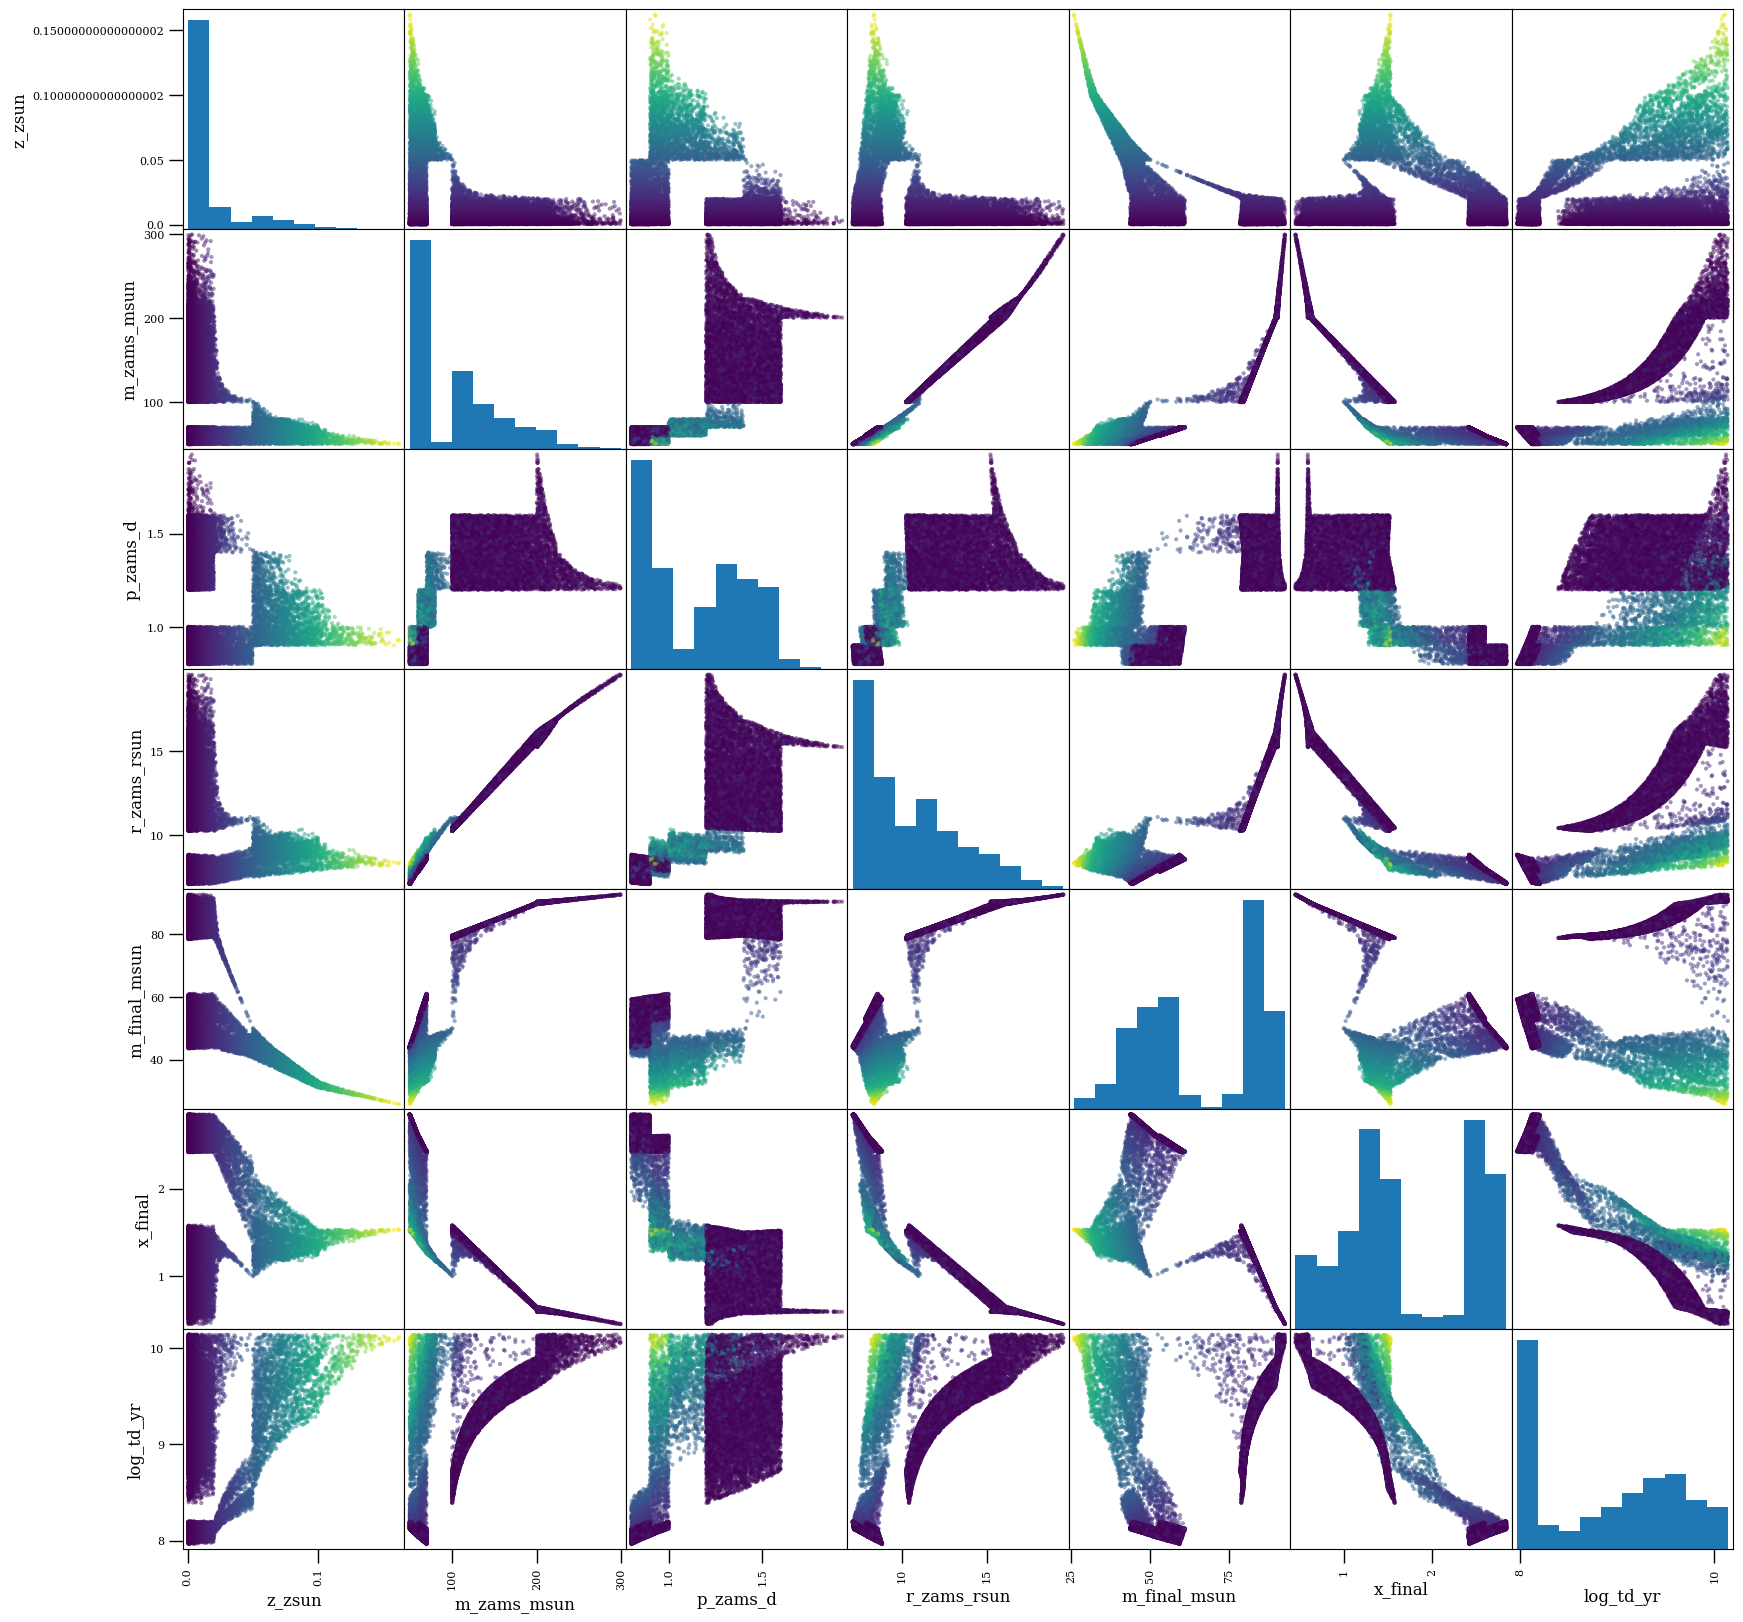

In [101]:
pd.plotting.scatter_matrix(df, c=df['z_zsun'], figsize=(20, 20))

for ax in plt.gcf().get_axes():
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

In [119]:
met_ranges = {
    0: '<Zsun/1000',
    1: 'Zsun/1000<Z<Zsun/100',
    2: 'Zsun/100<Z<Zsun/50',
    3: 'Zsun/50<Z<Zsun/20',
    4: 'Zsun/20<Z<Zsun/10',
    5: 'Zsun/10<Z<Zsun/5',
    6: 'Zsun/5<Z<Zsun/2',
    7: '>Zsun/2'   
}

met_bounds = [1/50, 1/20, 1/10, 1/5, 1/2, 1]

def set_met_range(row):
    for i, boundary in enumerate(met_bounds):
        if row.z_zsun <= boundary:
            return met_ranges[i]
    return met_ranges[-1]

df['Metallicity range'] = df.apply(set_met_range, axis=1)
df['Metallicity range'] = df['Metallicity range'].astype('category')

In [120]:
import seaborn as sns

<Axes: xlabel='m_final_msun', ylabel='Probability'>

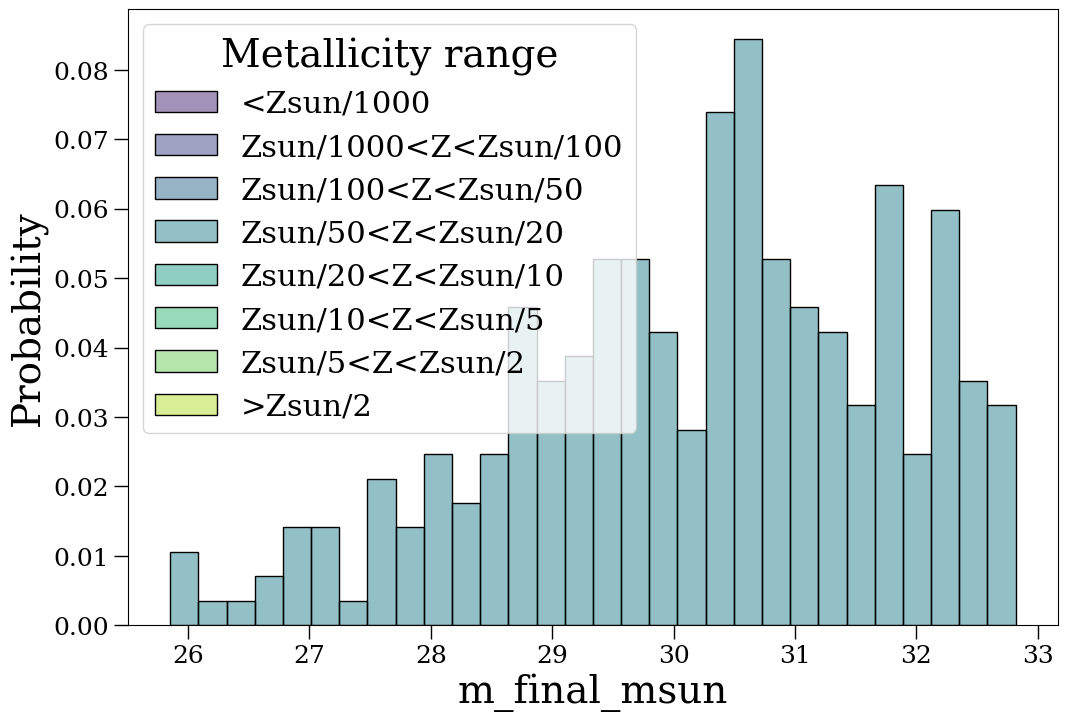

In [124]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(df[df.z_zsun > 1/10], x='m_final_msun', hue='Metallicity range', stat='probability', bins=30, alpha=0.5, ax=ax,
             hue_order=list(met_ranges.values()), palette='viridis')

(array([10045., 10105., 10113.,  9935., 10082.,  9971.,  9904.,  9998.,
        10146., 10104.,  9996.,  9869., 10013.,  9984.,  9951.,  9952.,
        10092.,  9908., 10156.,  9911.,  9754.,  9962., 10169.,  9894.,
        10259., 10069., 10026., 10048.,  9810., 10128.,  9891., 10008.,
         9790., 10130., 10155.,  9989., 10090.,  9960.,  9941., 10021.,
        10041.,  9936.,  9954., 10034.,  9993., 10035., 10065.,  9939.,
         9893.,  9983., 10017., 10028., 10144., 10047.,  9888.,  9921.,
         9912.,  9971.,  9912.,  9998.,  9973.,  9841., 10068., 10175.,
        10049., 10054., 10011., 10136., 10182.,  9789.,  9946., 10056.,
        10109., 10075.,  9882.,  9970.,  9942.,  9993., 10082., 10055.,
        10074.,  9960., 10181., 10133., 10063.,  9996.,  9969., 10047.,
         9796., 10155.,  9952.,  9970.,  9908.,  9995.,  9851.,  9974.,
         9610.,  9955.,  9977., 10006.]),
 array([-9.99999680e-01, -9.89999689e-01, -9.79999698e-01, -9.69999706e-01,
        -9.5999971

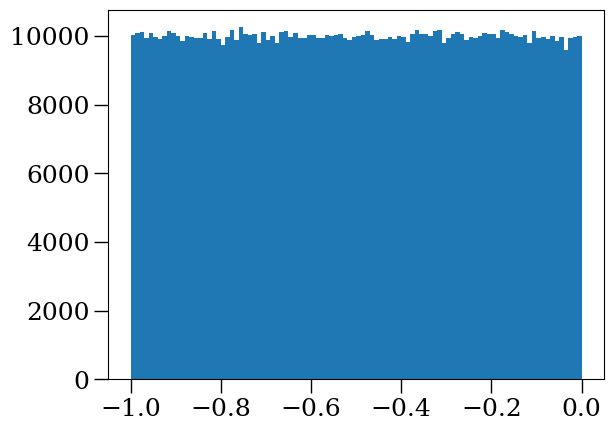

: 

In [ ]:
plt.hist(np.log10(sample[:, 0]), bins=100)

(array([ 513.,  481.,  503.,  330.,  291.,  300.,  281.,  292.,  262.,
         618., 1389., 1388., 1238., 1261., 1248., 1246., 1210., 1143.,
        1135., 1132., 1042., 1118., 1164., 1263., 1272., 1187., 1138.,
        1048., 1121.,  742.,  766.,  733.,  745.,  740.,  718.,  420.,
         155.,  146.,  161.,  169.,  141.,  126.,  143.,  129.,  159.,
         250.,  283.,  262.,  236.,  231.,  249.,  243.,  246.,  232.,
         226.,  199.,  192.,  176.,  167.,  204.,  169.,  163.,  168.,
         196.,  173.,  174.,  175.,  138.,   16.,   19.,   16.,   20.,
          13.,   21.,    4.,   27.,   20.,   13.,   14.,   13.,   10.,
          18.,   14.,   18.,   13.,   12.,   16.,   11.,   17.,   28.,
          12.,   16.,   11.,    8.,    8.,   11.,   13.,   13.,   14.,
           6.]),
 array([0.90002221, 0.93099006, 0.96195792, 0.99292577, 1.02389363,
        1.05486148, 1.08582933, 1.11679719, 1.14776504, 1.1787329 ,
        1.20970075, 1.24066861, 1.27163646, 1.30260432, 1.33357217

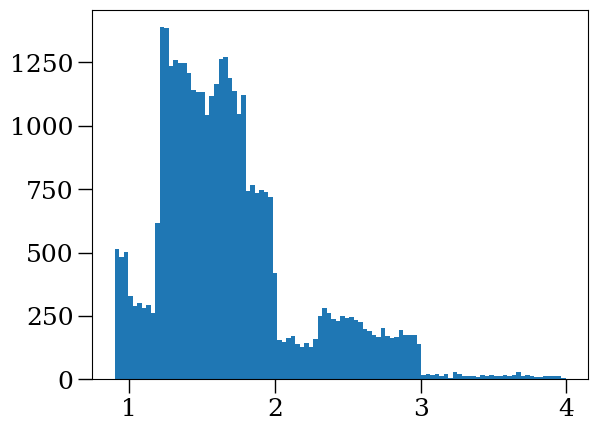

: 

In [ ]:
plt.hist(msample[:, 2], bins=100)

(array([[1.130e+03, 8.090e+02, 1.056e+03, 1.377e+03, 1.322e+03, 1.019e+03,
         9.710e+02, 2.570e+02, 1.810e+02, 1.600e+02, 1.560e+02, 1.700e+02,
         1.430e+02, 6.800e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [8.290e+02, 5.540e+02, 8.000e+02, 1.028e+03, 9.030e+02, 7.150e+02,
         7.000e+02, 2.140e+02, 1.240e+02, 1.220e+02, 1.140e+02, 1.130e+02,
         1.020e+02, 6.000e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [1.590e+02, 1.610e+02, 9.310e+02, 6.720e+02, 6.600e+02, 6.450e+02,
         4.820e+02, 8.400e+01, 2.100e+01, 1.050e+02, 9.600e+01, 9.500e+01,
         7.900e+01, 5.400e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00],
        [0.000e+00, 5.200e+01, 8.320e+02, 5.310e+02, 5.440e+02, 5.710e+02,
         3.760e+02, 2.100e+01, 0.000e+00, 7.600e+01, 6.200e+01, 5.700e+01,
         6.500e+01, 4.200e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
    

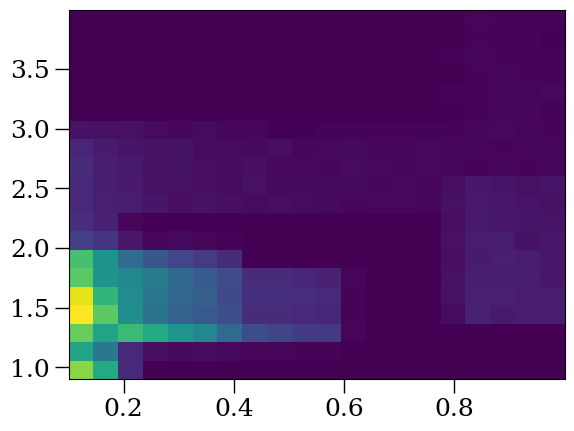

: 

In [ ]:
plt.hist2d(msample[:, 0], msample[:, 2], bins=20)

(array([[1.138e+03, 1.073e+03, 8.430e+02, 8.560e+02, 8.060e+02, 6.520e+02,
         4.500e+02, 4.010e+02, 3.230e+02, 2.560e+02, 2.120e+02, 2.040e+02,
         2.970e+02, 2.600e+02, 2.490e+02, 1.820e+02, 1.780e+02, 1.580e+02,
         1.370e+02, 1.440e+02],
        [8.320e+02, 7.730e+02, 6.340e+02, 6.220e+02, 5.540e+02, 4.290e+02,
         3.570e+02, 2.630e+02, 2.350e+02, 2.050e+02, 1.520e+02, 1.210e+02,
         2.460e+02, 2.110e+02, 1.460e+02, 1.590e+02, 1.250e+02, 1.140e+02,
         1.020e+02, 9.800e+01],
        [2.780e+02, 6.620e+02, 7.580e+02, 6.210e+02, 3.480e+02, 2.470e+02,
         2.000e+02, 1.550e+02, 1.260e+02, 1.060e+02, 1.010e+02, 7.200e+01,
         1.100e+02, 9.000e+01, 8.100e+01, 8.200e+01, 5.400e+01, 6.100e+01,
         3.500e+01, 5.700e+01],
        [1.110e+02, 5.720e+02, 7.080e+02, 5.570e+02, 2.240e+02, 1.960e+02,
         1.380e+02, 1.210e+02, 9.000e+01, 8.400e+01, 7.400e+01, 5.200e+01,
         6.500e+01, 4.600e+01, 4.600e+01, 3.000e+01, 3.400e+01, 2.900e+01,
    

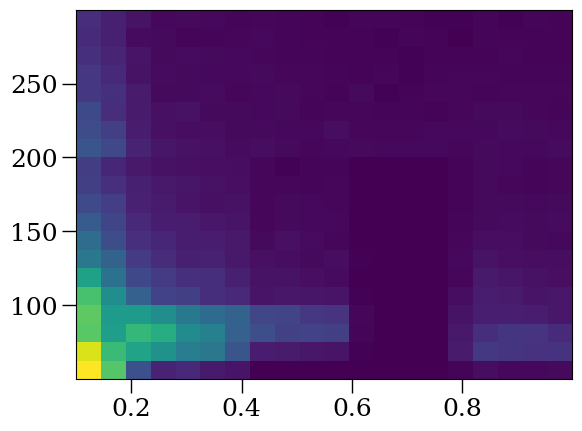

: 

In [ ]:
plt.hist2d(msample[:, 0], msample[:, 1], bins=20)

(array([[1747.,  403.,  393.,  162.,   45.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.],
        [ 371., 1093., 2139., 1096.,  438.,  106.,  126.,   13.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.],
        [   0.,  138., 2234., 1741., 1112.,  519.,  211.,   18.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.],
        [   0.,  119., 1758., 1513., 1064.,  496.,  130.,   16.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.],
        [   0.,    0.,    0.,  329.,  726.,  865.,  706.,  133.,   86.,
           87.,   82.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.],
        [   0.,    0.,    0.,  252.,  562.,  706.,  551.,  123.,   61.,
           78.,   54.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0., 

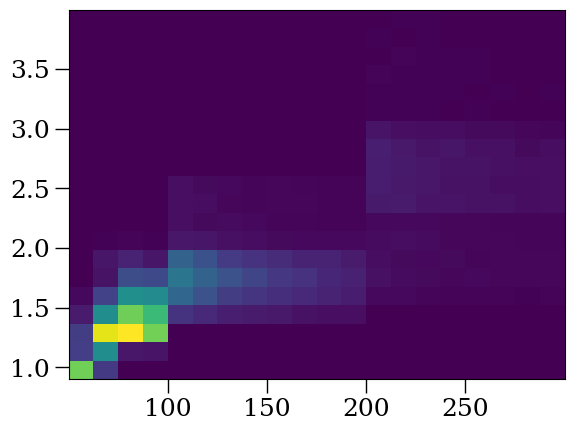

: 

In [ ]:
plt.hist2d(msample[:, 1], msample[:, 2], bins=20)

(array([ 513.,  481.,  503.,  330.,  291.,  300.,  281.,  292.,  262.,
         618., 1389., 1388., 1238., 1261., 1248., 1246., 1210., 1143.,
        1135., 1132., 1042., 1118., 1164., 1263., 1272., 1187., 1138.,
        1048., 1121.,  742.,  766.,  733.,  745.,  740.,  718.,  420.,
         155.,  146.,  161.,  169.,  141.,  126.,  143.,  129.,  159.,
         250.,  283.,  262.,  236.,  231.,  249.,  243.,  246.,  232.,
         226.,  199.,  192.,  176.,  167.,  204.,  169.,  163.,  168.,
         196.,  173.,  174.,  175.,  138.,   16.,   19.,   16.,   20.,
          13.,   21.,    4.,   27.,   20.,   13.,   14.,   13.,   10.,
          18.,   14.,   18.,   13.,   12.,   16.,   11.,   17.,   28.,
          12.,   16.,   11.,    8.,    8.,   11.,   13.,   13.,   14.,
           6.]),
 array([0.90002221, 0.93099006, 0.96195792, 0.99292577, 1.02389363,
        1.05486148, 1.08582933, 1.11679719, 1.14776504, 1.1787329 ,
        1.20970075, 1.24066861, 1.27163646, 1.30260432, 1.33357217

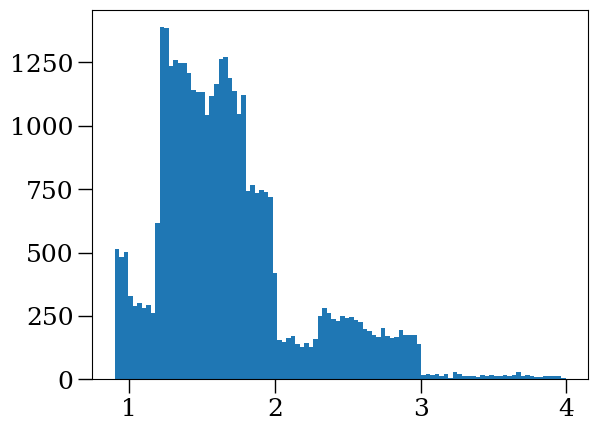

: 

In [ ]:
plt.hist(msample[:, 2], bins=100)

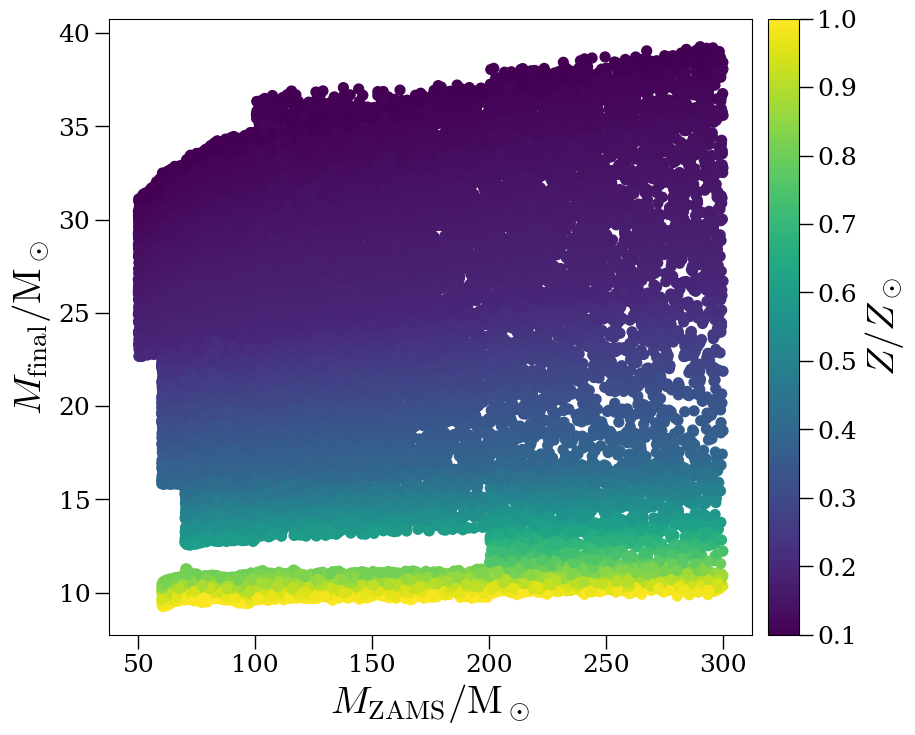

: 

In [ ]:
x = msample[:, 1]
y = msample[:, 4]
c = msample[:, 0]

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(x, y, c=c, s=50)
ax.set_xlabel('$M_\mathrm{ZAMS}/\mathrm{M}_\odot$')
ax.set_ylabel('$M_\mathrm{final}/\mathrm{M}_\odot$')

sm = ScalarMappable(cmap=cm.viridis, norm=Normalize(vmin=0.1, vmax=1.0))
cb = fig.colorbar(sm, ax=ax, location='right', pad=0.02) 
cb.set_label('$Z/Z_\odot$')

#ax.set_yscale('log')
#ax.set_xscale('log')

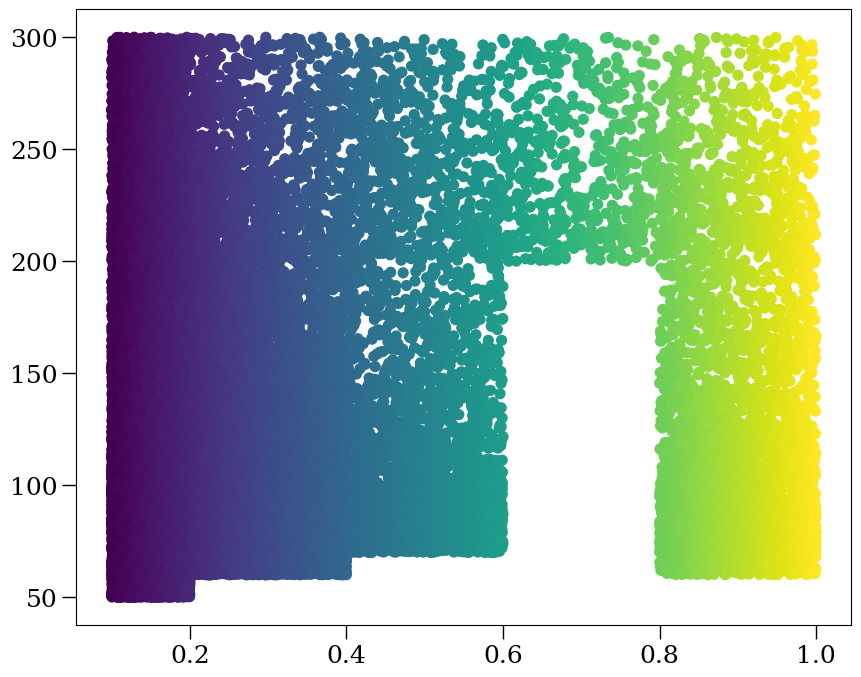

: 

In [ ]:
x = msample[:, 0]
y = msample[:, 1]
c = msample[:, 0]

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(x, y, c=c, s=50)
#ax.set_yscale('log')
#ax.set_xscale('log')

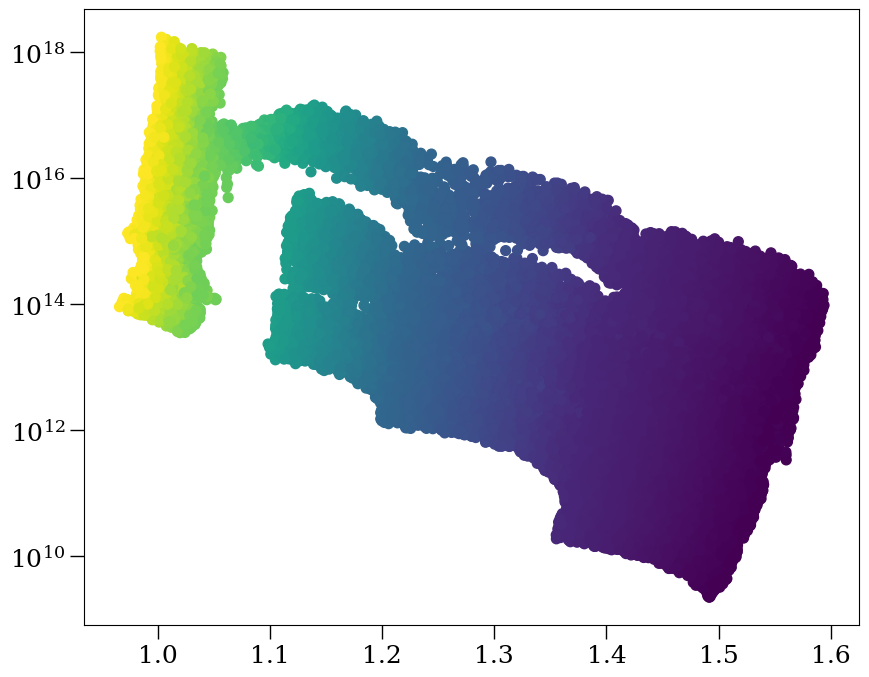

: 

In [ ]:
x = sample[:, 4]
y = sample[:, 6]
c = sample[:, 0]

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(np.log10(x), y, c=c, s=50)
ax.set_yscale('log')